# Building and Hyperparameter Tuning of Multilayer Perceptron for Risk Assesment
### By: Ana María Ramos. 
### Advisor: Arles Rodríguez.


In this notebook, we'll explore the process of building a Multilayer Perceptron (MLP), a type of Feed Forward Neural Network which generalizes a Perceptron to a model with at least one hidden layer, and apply it to predict risk ratings for life insurance applicants. To accomplish this, we'll utilize the TF Keras Sequential API for constructing the risk classifier, and leverage the TF KerasTuner API for efficient hyperparameter tuning of the model.

The dataset we'll work with was initially released for a Kaggle competition sponsored by the Prudential Financial company [[1]](#R-1). It encompasses more than a hundred variables describing various attributes of life insurance applicants. Our objective is to predict the "Response" variable for each applicant in the test set. "Response" represents an ordinal measure of risk categorized into 8 levels.


**By the end of this lab, you'll be able to:**

- Construct and train a Multilayer Perceptron Neural Network in Keras TensorFlow for a multiclass classification problem.
- Perform hyperparameter tuning of your Keras Neural Network models through disctinct automated techniques such as Grid Search, Random Search, and Hyperband.
- Utilize customized metrics for the hyperparameter tuning process.
- Familiarize yourself with the Quadratic Weighted Kappa metric tailored for ordinal classification tasks and integrate it into your projects.
- Apply your knowledge of neural network models and projects to address a range of actuarial and financial tasks related to risk classification.

## Table of Content

- [1 - Packages](#1)
- [2 - Load and Explore the Data](#2)
- [3 - Build model and tune hyperparamters](#3)
    - [3.1 - Build the Model and Define the Hyperparameters](#3-1)
        - [3.1.1 - Special case for mini-batch size tuning](#3-1-1)
        - [Exercise 1 - Defining Hyperparameters within the Model](#ex-1)
    - [3.2 - Search for the Best Hyperparameters](#3-2)
        - [Exercise 2 - Search for the Best Hyperparameters](#ex-2)
- [4 - Expanded Keras Tuner Features](#4)
    - [4.1 - Use Custom Metrics](#4-1)
    - [4.2 - Tailor the Search Space](#4-2)
    - [Exercise 3 - Prioritized Hyperparameter Tuning with Custom Metric](#ex-3)
- [5 - Fit and Evaluate Tuned Model](#5)
    - [Exercise 4 - Fit and Predict with Tuned Model](#ex-4)
    - [5.1 - See Tuned Model Perfomance](#ex-3)
- [6 - Bibliography](#6)

<a name='1'></a>
## 1 - Packages

Let's start by importing all the necessary libraries for building our neural network model, tuning the hyperparameters, and evaluating the model's performance.

In [1]:
#import sys
import math
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # graphs/plotting
import seaborn as sns
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from scikitplot.metrics import plot_roc, plot_confusion_matrix
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import log_loss
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.13.0


<a name='2'></a>
## 2 - Load and Explore the Data

Execute the cells below in order to load and generate a summary of the data.

In [2]:
def load_data():
    
    x_train = pd.read_csv('X_train_preprocessed.csv')
    x_valid = pd.read_csv('X_valid_preprocessed.csv')
    x_test = pd.read_csv('X_test_preprocessed.csv')
    y_train = pd.read_csv('Y_train.csv')
    y_valid = pd.read_csv('Y_valid.csv')
    y_test = pd.read_csv('Y_test.csv')
    x_train = x_train.set_index('Id')
    x_valid = x_valid.set_index('Id')
    x_test = x_test.set_index('Id')
    y_train = y_train.set_index('Id')
    y_valid = y_valid.set_index('Id')
    y_test = y_test.set_index('Id')
    x_full=pd.concat([x_train, x_valid, x_test])
    y_full=pd.concat([y_train, y_valid, y_test])
    x_full=x_full.sort_index()
    y_full=y_full.sort_index()
    # Convert from pandas to numpy
    x_train=x_train.to_numpy().astype('float32')
    x_valid=x_valid.to_numpy().astype('float32')
    x_test=x_test.to_numpy().astype('float32')

    
    return x_full, y_full, x_train, x_valid, x_test, y_train, y_valid, y_test

In [3]:
# Load the data
x_full, y_full, x_train, x_valid, x_test, y_train, y_valid, y_test= load_data()

In [4]:
# Review the main characteristics of the dataset features
print("Data Set Features Description\n------------------------------\n", x_full.dtypes)
x_full.describe()

Data Set Features Description
------------------------------
 Product_Info_4         float64
Product_Info_6         float64
Ins_Age                float64
BMI                    float64
Employment_Info_3      float64
Employment_Info_5      float64
InsuredInfo_4          float64
InsuredInfo_5          float64
InsuredInfo_6          float64
InsuredInfo_7          float64
Insurance_History_1    float64
Insurance_History_2    float64
Insurance_History_3    float64
Insurance_History_4    float64
Insurance_History_9    float64
Family_Hist_1          float64
Medical_History_3      float64
Medical_History_4      float64
Medical_History_6      float64
Medical_History_11     float64
Medical_History_13     float64
Medical_History_14     float64
Medical_History_16     float64
Medical_History_17     float64
Medical_History_20     float64
Medical_History_22     float64
Medical_History_23     float64
Medical_History_26     float64
Medical_History_27     float64
Medical_History_28     float64
Medical_

,Product_Info_4,Product_Info_6,Ins_Age,BMI,Employment_Info_3,Employment_Info_5,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,InsuredInfo_7,...,Medical_Keyword_40,Medical_Keyword_48,Product_Info_2_A6,Product_Info_2_A7,Product_Info_2_A8,Product_Info_2_D1,Product_Info_2_D2,Product_Info_2_D3,Product_Info_2_D4,Product_Info_2_E1
count,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,...,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000
mean,0.328952,0.836800,0.405567,0.436295,0.150452,0.142958,0.883666,0.013590,0.409188,0.019265,...,0.056954,0.054496,0.035331,0.023290,0.115104,0.110372,0.105859,0.241171,0.182078,0.044577
std,0.282562,0.369551,0.197190,0.129853,0.357517,0.350033,0.320627,0.115783,0.491688,0.137458,...,0.231757,0.226995,0.184617,0.150825,0.319150,0.313356,0.307659,0.427798,0.385912,0.206374
min,0.000000,0.000000,0.000000,-0.062516,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.076923,1.000000,0.238806,0.347102,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.230769,1.000000,0.402985,0.417050,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.487179,1.000000,0.567164,0.503654,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
# Display the features of the first 5 data points
x_full.head()

,Product_Info_4,Product_Info_6,Ins_Age,BMI,Employment_Info_3,Employment_Info_5,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,InsuredInfo_7,...,Product_Info_2_A8,Product_Info_2_D1,Product_Info_2_D2,Product_Info_2_D3,Product_Info_2_D4,Product_Info_2_E1,KMeansCluster_4,KMeansCluster_5,KMeansCluster_11,KMeansCluster_13
Id,,,,,,,,,,,,,,,,,,,,,
2,0.076923,0.0,0.641791,0.280685,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,False,False,False,False
5,0.076923,1.0,0.059701,0.226794,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False
6,0.076923,1.0,0.029851,0.393070,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,False,False,False,False
7,0.487179,1.0,0.164179,0.311955,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
8,0.230769,1.0,0.417910,0.388039,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


We have approximately 59,000 data points describing life insurance applicants' information related to age, employment status, medical conditions, and other factors. The dataset has already been preprocessed and normalized [[10]](#R-10), with the independent variables being now of type float. If you're interested in obtaining the raw data you can refer to [[1]](#R-1). 

Let's now take a look at the response variable of our dataset.

In [6]:
print("Data Set Labels: \n\n", y_full.dtypes)
y_full.describe()

Data Set Labels: 

 Response    int64
dtype: object


,Response
count,59381.000000
mean,5.636837
std,2.456833
min,1.000000
25%,4.000000
50%,6.000000
75%,8.000000
max,8.000000


In [7]:
# Display first 5 values of applicants' risk ratings
y_full.head()

,Response
Id,
2,8
5,4
6,8
7,8
8,8


Text(0.5, 1.0, 'Response Distribution')

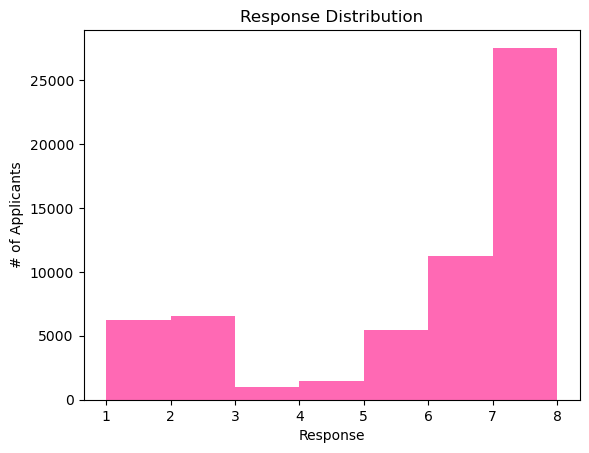

In [8]:
# Visualize the distribution of applicants' risk ratings in the full dataset.
plt.hist(y_full['Response'], bins=sorted(y_full['Response'].unique()), color = "hotpink")
plt.xlabel('Response')
plt.ylabel('# of Applicants')
plt.title('Response Distribution')

The histogram above shows the full dataset's distribution of applicants by their determined risk ratings (i.e. Response). We can see that this variable are integers ranging from 1 to 8. Now, the TensorFlow neural networks will only take a categorical variable of k classes to be integers from 0 to k-1, so we'll need to encode the data in this way.

In [9]:
# Label-encode each dataset for compatibility with keras TensorFlow API
le = LabelEncoder()
# Convert each set of class labels (1-8) into encoded labels (0-7).
y_train = le.fit_transform(y_train)
y_valid = le.transform(y_valid)
y_test = le.transform(y_test)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


<a name='3'></a>
## 3 - Build model and tune hyperparameters

We'll construct a multilayer perceptron with RELU activation for the hidden layers and softmax activation for the output layer, as it's standard in multiclassification problems. We'll tune the number of layers, units per layer, learning rate, and mini-batch size hyperparameters, by employing the random search optimizer method, although you'll notice that the Keras tuner library offers various search algorithms.

<a name='3-1'></a>
## 3.1 - Build the Model and Define the Hyperparameters

To tune the hyperparameters with the Keras Tuner library, we need to define and build our Keras model within the `build` method of a subclass of the Keras Tuner `HyperModel` class. Here's a sketch outlining the structure of the code to achieve this:

```python
class MyHyperModel(kt.HyperModel):
    def build(self, hp):        

        model = keras.Sequential()                             
        model.add(...)  # Build your model here
        ...
        model.compile(...)  # Compile the model
        
        return model  # Return the compiled model                                       
    
```


Now, you'll create a model using the TensorFlow Keras Sequential API, which allows you to build layer by layer, ideal for models with exactly one input tensor and one output tensor per layer. 

To define the hyperparameters, utilize the hp argument of the build function, which is passed as a HyperParameters class instance during execution. The method of the HyperParameters class to use depends on the type of the hyperparameter to be tuned. For example, to tune the number of units in the first hidden layer, use the `HyperParameters.Int()` method, like in the following example:


```python

class MyHyperModel(kt.HyperModel):
   def build(self, hp):
    
       model = keras.Sequential()      
 
       model.add(keras.layers.Dense(  
           units = hp.Int('units', min_value=12, max_value=90),  # Make the number of units an integer type hyperparameter
           activation = 'relu'))                                         
   
       ...   # Finish building and compiling model    

       return model  # Return the compiled model
     
```
You can also tune the number of hidden layers of your model:

```python

class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        
        model = keras.Sequential()  
        
        # Define a hyperparameter for the number of hidden layers
        hp_layers = hp.Int("n_layers", min_value=6, max_value=13, step=3) 
        
        # Add hidden layers dynamically based on the hyperparameter
        for i in range(hp_layers):
             model.add(keras.layers.Dense(units=20, activation='relu'))
          
        ...  # Finish building and compiling model    
      
        return model  # Return the compiled model
    
```

The `HyperParameters.Int()` method, as demonstrated above, enables you to specify the name of the integer hyperparameter along with its minimum and maximum values, and optionally a step size to define the search grid for the hyperparameter. By default, it employs linear sampling, but you have the flexibility to specify the type of sampling you prefer.

This method provides an effective means to tune all your integer hyperparameters. However, if you wish to tune other types of hyperparameters, such as the activation function of certain hidden layers or the learning rate, the HyperParameters class offers several additional methods for this purpose [[9]](#R-9). Here's a list of the <a name='hyper_meth'></a> available options:

- `HyperParameters.Int(name, min_value, max_value, step=None, sampling="linear", ...)`: Integer hyperparameter.
- `HyperParameters.Float(name, min_value, max_value, step=None, sampling="linear", ...)`: Floating-point value hyperparameter.
- `HyperParameters.Boolean(name, ...) `: Boolean hyperparameter (choice between True and False).
- `HyperParameters.Choice(name, values, ordered=None, ...)`: Choice of one value among a predefined set of possible values passed within a list.

<a name='3-1-1'></a>
## 3.1.1 - Special case for mini-batch size tuning

The mini-batch size is a hyperparameter that has been consistently found to be crucial to optimize. However, it cannot be directly modified within the build method of the class since it lies outside the scope of the model implementation as opposed to other hyperparameters. To tune it, we need to override the fit method of the parent HyperModel class. By doing so, we can ensure that the mini-batch size is passed as an argument to the ```model.fit``` method. Don't fret, though! The code required for this adjustment is straightforward and illustrated in the following snippet.


```python
class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        model = keras.Sequential()                             # Define model
        ...                                                    # Build model by adding layers 
      
        model.compile(optimizer = 'adam',                        # Compile model
                      loss = keras.losses.CategoricalCrossentropy(), 
                      metrics = ['accuracy'])  
      
        return model                                           # Return your compiled model
    
    def fit(self, hp, model, *args, **kwargs):
           return model.fit(
               *args,
               # Define the "batch_size" hyperparameter here
               batch_size = hp.Choice("batch_size", [32, 64, 128, 256]), 
               **kwargs,
           )
```

<a name='ex-1'></a>
## Exercise 1 - Defining Hyperparameters within the Model

In this exercise you'll construct a multilayer perceptron for an eight-class classifier. We'll define several hyperparameters to be  fine-tuned later, such as the learning rate, mini-batch size, number of hidden layers, their activation function, and the number of units in each layer. The basic code structure has already been implemented for you and you just have to complete the missing parts.

Here are the specifications you need to consider for each hyperparameter. Remember to use the appropiate `Hyperparameters` [methods](#hyper_meth) for each case:

- **Number of hidden layers:** Name this parameter `'hidden_layers'`. Set the search space for this parameter to include all integers ranging from 1 to 5. 

- **Number of units in each layer:** Name the parameter representing the number of units of the ith layer `'units_i'`. Set the search space for this parameter to include integers ranging from 15, to 120, with a step of 5.

- **Activation function for hidden layers:** Name this hyperparameter `'layers_activation'`. Set the tuner to choose between the `'relu'`, `'sigmoid'`, and `'tanh'` activation functions [[8]](#R-8). 

- **Learning rate:** Name this hyperparamter `'learning_rate'`. Set the search space of this hyperparamter to be range between 0.01 and 0.001 using logarithmic sampling. The string representation for this is type of sampling is `'log'`.

- **Mini-batch size:** Name this hyperparameter `'batch_size'`. Set the tuner to choose between the values 16, 32, 64, 128, 256,  and 512. Remember the format to pass these values for the `Hyperparameters.Choice()` method is within a list.

 **Note:** The choice of the **cross entropy loss function** in the ```model.compile()``` method for your classification tasks depends on how the labels are encoded. If the class variable of the k-class classifier is encoded by an integer ranging from 0 to k-1, then use the `keras.losses.SparseCategoricalCrossentropy()` loss function. Otherwise, if it's encoded in one-hot representation, i.e., by a k-length vector where the entry corresponding with the class is 1 and all other entries are zero, then use the `keras.losses.CategoricalCrossentropy()` loss function. You can refer back to the [2 - Load and Explore the Data](#2) section of this notebook to see the way the response variable is encoded for the life insurance applicants.


In [10]:
class InitialHyperModel(kt.HyperModel):
    def build(self, hp):
        
        model = keras.Sequential()
        
        ## START CODE HERE
        
        # Define the hidden layers hyperparameter and save it in the hp_layers variable (≈1 line)
        
        hp_layers = hp.Int('hidden_layers', 1, 5)
          
        # Define the activation function hyperparameter and save it in the hp_activation variable (≈1 line)
        
        hp_activation = hp.Choice('activations', ['relu', 'sigmoid', 'tanh'])
        
        # Tune the learning rate for the optimizer and save it in the hp_learning_rate variable (≈1 line)
        
        hp_learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="linear")
          
        ## END CODE HERE

        # Add hidden layers dynamically based on the hyperparameter
        for i in range(1,1+hp_layers):
            
             model.add(
                 keras.layers.Dense(
                     
                     ## START CODE HERE
                     
                     # Tune the number of units in each hidden layer (≈1 line)
                     # units=hp.Int('units_'+str(i),...),   
                     
                     units=hp.Int('units_'+str(i), min_value=15, max_value=120, step=5),
                     
                     # Set activation as the hyperparameter activation variable (≈1 line)
                     
                     activation=hp_activation,
                     
                     ## END CODE HERE
                 )
             )
        
        # Add output layer of the 8-class classifier network
        model.add(keras.layers.Dense(8, activation='softmax'))
     
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                      ## START CODE HERE
                      
                      # Specify the loss function for the model (≈1 line)
                      # loss=...,   
                      
                      loss = keras.losses.SparseCategoricalCrossentropy(),
                      
                      ## END CODE HERE

                      metrics=['accuracy'])  
    
        return model
    
    
    def fit(self, hp, model, *args, **kwargs):
            return model.fit(
                *args,
                ## START CODE HERE
                
                # Set batch size as a hyperparameter (≈1 line)
                batch_size=hp.Choice("batch_size", [16, 32, 64, 128, 256, 512]),
                
                ## END CODE HERE
                **kwargs,
            )
               

<a name='3-2'></a>
## 3.2 - Search for the Best hyperparameters


Now, let's delve into searching for the optimized hyperparameters of our model, which were defined within the subclass of the `keras_tuner.HyperModel` class. The Keras Tuner library provides several tuning methods for our search, each implemented as a subclass of the `Tuner()` class. These tuning methods include the GridSearch Tuner, RandomSearch Tuner, BayesianOptimization Tuner, and Hyperband Tuner. [[2]](#R-2)

Once you've settled on your preferred tuning method, the next step is to instantiate the corresponding Keras Tuner class. You'll need to specify the subclass of the basic `HyperModel` class where your model is defined, along with an objective metric against which the hyperparameter optimization will be performed. Below is an example of instantiating the GridSearch Tuner class to tune the hyperparameters of a model defined in the subclass `MyHyperModel()`:


```python

class MyHyperModel(kt.HyperModel):
    def build(self, hp):        
        
        model = keras.Sequential()                             
        model.add(...)  # Construction of the model
        model.compile(...)  # Compilation of the model 
        
        return model  # Return the compiled model  

tuner = keras_tuner.GridSearch(
    hypermodel=MyHyperModel(), # Name of the class where the model was built
    objective="val_loss",      # The metric to optimize
    max_trials=none,           # Maximum number of trials (hyperparameter combinations) to test
    executions_per_trial=2,    # Number of executions per trial
    overwrite=True,            # Whether to overwrite the results of a previous run
    directory=None,            # Directory to save logs and checkpoints
    project_name=None,         # Name of the project (if saved)
)

```
Here's a description of the main argument:
- **hypermodel**: The subclass of the `HyperModel` class where your model is defined.
- **objective**: The metric to optimize, in this case, minimizing validation loss. Common strings for this parameter include **'val_loss'** and **'val_accuracy'**, but you can also use any Keras built-in metric [[3]](#R-3) or loss [[4]](#R-4) name, such as 'mean_squared_error'. Add 'val_' at the beginning of the metric name string to specify that the metric to optimize is to be evaluated on the validation set rather than the training set.  
  **Note**: The metric can be passed also as a ```keras_tuner.Objective``` instance [[5]](#R-5), as we'll see an example of later in this tutorial. We can also provide a list of metrics, and the sum of each with its corresponding sign will be minimized.
- **max_trials**: The maximum number of different hyperparameter combinations to try. If left unspecified, it runs until the search space is exhausted.
- **executions_per_trial**: The number of executions (training runs) per trial, allowing for different weight initializations for each set of hyperparameter values.


It's important to note that in this tutorial, we'll always optimize our hyperparameters with respect to the validation set, as this was the purpose of splitting it initially. Therefore, any metric or loss string to be passed to the objective argument of the tuners should be in the format `f"val_{name_of_metric}"`.

All tuners share similar initialization arguments and default values, although some of them may vary from tuner to tuner. After instantiating the Tuner object, you can access various methods to manage the optimization process:

<a name='hyper_func'></a>
- ```tuner.search_space_summary()```: Displays the summary of the hyperparameter search space.
- ```tuner.search()```: Performs the hyperparameter search using the corresponding tuning method.
- ```tuner.get_best_hyperparameters()```: Retrieves the best hyperparameters found during the search.
- ```tuner.get_best_models()```: Obtains the models with the optimized hyperparameters.


Once you have your optimized model, you can proceed to fit it, evaluate it, and make predictions just like with any regular Keras model.

<a name='ex-2'></a>
## Exercise 2 - Fine-tuning the Hyperparameters

In this exercise, you will perform a random search for the hyperparameters defined in the model built in the previous exercise and prepare your optimized model for the fitting and predicting steps. 

First, start by instantiating the RandomSearch tuner class with the following specifications:

- Set the hypermodel argument to be the class `InitialHyperModel()`,  where you built the model in the previous exercise.
- Set the objective metric to be the accuracy of the validation set.
- Limit the search to a maximum of 6 trials. 

In [11]:
initial_tuner = kt.RandomSearch(
    
## START CODE HERE
    
# Specify the required arguments for the tuner (≈3 lines)
#   hypermodel =...,    
#   obective =...,    
#   max_trials =...,    

InitialHyperModel(),
objective = 'val_accuracy',
max_trials = 5,
    
## END CODE HERE
    
overwrite = True,        
seed = 5)

Now let's examine the hyperparameters search space of the `initial_tuner` you just initialized.

In [12]:
### START CODE HERE

## Display the hyperparameters to be tuned
## initial_tuner.search_... (≈1 line)
initial_tuner.search_space_summary()

### END CODE HERE

Search space summary
Default search space size: 4
hidden_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
activations (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid', 'tanh'], 'ordered': False}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 15, 'max_value': 120, 'step': 5, 'sampling': 'linear'}


The next steep is to proceed with the random search for the best hyperparameters. The tuner will train each model with the training set for a maximum of 5 epochs, and then select the best model based on their accuracy performance on the validation data.

In [13]:
initial_tuner.search(x_train, y_train, epochs=5, validation_data=(x_valid, y_valid))

Trial 5 Complete [00h 00m 05s]
val_accuracy: 0.4958740174770355

Best val_accuracy So Far: 0.5111990571022034
Total elapsed time: 00h 00m 39s


Now that the search is complete, let's retrieve and save the model with the optimized hyperparameters, and display its values.

In [14]:
# Get the optimal model
initial_best_model = initial_tuner.get_best_models()[0]

# Get and print the optimal hyperparameters
initial_best_hps=initial_tuner.get_best_hyperparameters(num_trials=1)[0]
print(initial_best_hps.values)

{'hidden_layers': 3, 'activations': 'relu', 'learning_rate': 0.006803545685322677, 'units_1': 110, 'units_2': 30, 'units_3': 120, 'units_4': 115, 'batch_size': 256}


Finally, utilize the evaluate method of the Keras Tuner model class to assess our model's performance with respect to the metrics specified during the compilation of the model.

In [15]:
# Evaluate model on validation set with loss and accuracy metrics
initial_best_model.evaluate(x_valid, y_valid)

372/372 [==============================] - 0s 775us/step - loss: 1.3461 - accuracy: 0.5112


[1.3461064100265503, 0.5111990571022034]

<a name='4'></a>
## 4 - Expanded Keras Tuner Features

While the basic framework we've covered so far is sufficient for most typical needs during the hyperparameter tuning process of your neural network models, Keras-Tuner provides numerous alternatives and additional features for you to incorporate into your deep learning project. We will explore a couple of them in this section.

<a name='4-1'></a>
## 4.1 - Use Custom Metrics

In addition to optimizing hyperparameters with respect to predefined metrics and losses provided by Keras, you can also use your own customized metric if you find the default metrics insufficient for selecting the best model for your task [[6](#R-6)]. One approach to indicate Keras to calculate the average of a custom metric evaluated on each mini-batch and use that as the overall metric. Here are the steps to implement this:


 **1.** Define your customized metric function with signature of the form `name_customized_metric(y_true, y_pred)`,  which takes the vectors `y_true` and `y_pred` as parameters and returns a scalar score.

 **2.** Include the custom metric function in the list of metrics during the compilation of the model.

 **3.** Pass a `keras_tuner.Objective`instantiation to the objective argument of the Keras Tuner initializer, with the string `'val_{name_customized_metric}'` for the first parameter, and the optimization direction for the second parameter. The latter should be either one of the "min" or "max" strings. 

Here's an example.
```python

# Define your custom metric function
def my_metric_fn(y_true, y_pred):                            
    
    squared_difference = ops.square(y_true - y_pred)
    return ops.mean(squared_difference, axis=-1) 


class MyHyperModel(kt.HyperModel):
    def build(self, hp): 
        model = keras.Sequential()                   
        ...                                                    
       
        model.compile(optimizer = 'adam',                       
                      loss = 'categorical_crossentropy',
                      # Include your custom metric in the compilation metrics
                      metrics = [my_metric_fn, 'accuracy',...])    
      
        return model                                           
    
      ...                                                    
    
tuner = kt.RandomSearch(
MyHyperModel(),
# Pass the custom metric with the established format to the tuners' objective
objective=kt.Objective("val_my_metric_fn", "max"),                    
max_trials=5)                                                
                                                             
```


<a name='4-2'></a>
## 4.2 - Tailor the Search Space

Another feature of Keras Tuner is the ability to tune a subset of hyperparameters without modifying the hypermodel. This can be useful for when resource constraints arise, and for conducting prioritized hyperparameter searches, which means to first conduct the tuning of the most important hyperparameters, and let the least important ones to be tuned last. Here's how to tailor the search space:

1. Define the complete set of hyperparameters within the model construction, and include default values for them. To do this you just have to specify the default parameter in the hyperparameter definition:

  ```python
  hp.Int("units", min_value=32, max_value=128, step=32, default=64)
  ```
    Keras-Tuner will give any hyperparameter a default value in case you don't specify it.
  
2. Instantiate a `keras_tuner.HyperParameters()` object, and use it to redefine only the hyperparameters you want to tune in the current search using the same names as the originals.

3. Pass your Hyperparameter object as an argument for the `hyperparameters` parameter of the tuner. 
4. Set the `tune_new_entries` parameter of the tuner to False to prevent not redefined parameters from being tuned and to allow them take their default values.


Here's an example:

```python

# Define model and all hyperparameters
class MyHyperModel(kt.HyperModel):                        
       def build(self, hp):
        
           model = keras.Sequential()                             
           model.add(
               # Add a hyperparameter for the layers' units with default value 64 
               layers.Dense(                                 
                   units = hp.Int("units", min_value=32, max_value=128, step=32, default=64)
               )
           )
           ...                      
       
           model.compile(
               optimizer=keras.optimizers.Adam(
                   # Add a hyperparameter for learning rate
                   learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4]) 
               ),
               ...
           )
       
           return model        

# Instantiate a Hyperparameters object and save it as hp            
hp = keras_tuner.HyperParameters()                          

# This will override the `learning_rate` parameter 
hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")  #

tuner = keras_tuner.RandomSearch(
    hypermodel = build_model,
    # Pass hp as value for the "hyperparameters" argument of the tuner    
    hyperparameters = hp,
    # Set the parameter below to False to prevent parameters not overriden with the hp object from being tuned
    tune_new_entries = False,
    objective = "val_accuracy",
)
```
In the previous example, the complete hyperparameters space include "units", and "learning_rate" as a choice hyperparameter. However, in the defined tuner, only the "learning_rate" hyperparameter will be tuned (notice that this time, as a float hyperparameter type), and the "units" hyperparameter will be set to its default value 64.

<a name='ex-3'></a>

## Exercise 3 - Prioritized Hyperparameter Tuning with Custom Metric

In this exercise, we'll conduct a prioritized hyperparameter tuning, leveraging a custom metric to enhance our model's performance. While conventional metrics like accuracy, F1-Score, precision, and recall serve well in many classification tasks—such as identifying road signals, hand gestures, or domestic animals from images—, they may fall short when handling ordinal response variables. This limitation arises from the fact that they penalize predictions that are significantly far from the true value to the same degree as those that fall very close to it.


Because our response variable involves rating life insurance applicants on a scale from 1 to 8, in this assignment we'll integrate the Quadratic Weighted Kappa (QWK) [[1]](#R-1) as a cutomized metric into the tuning process. This metric considers the ordinal nature of the classification task, by measuring the agreement between two ratings, typically ranging from 0 (indicating random agreement) to 1 (indicating complete agreement), although it can take on negative values in case the model performance is worst than a random classifier. Since it is not readily available in Keras, we've provided its function implementation for you.


### 1 - Define the Quadratic Weighted Kappa metric function

You don't need to modify the metric function definition, but you'll use this function for the next step.

In [16]:
# Metric for the hyperparameter optimization of ordinal classification tasks

def QuadraticWeightedKappa(y_true, y_pred_probs, N=8):
    
    """
    Calculate quadratic weighted kappa metric.

    Args:
    - y_true: tf.Tensor of true labels (actual risk) 
    - y_pred_probs: tf.Tensor of predicted probabilities (predicted risk) 
    - N: number of possible ratings

    Returns:
    - Quadratic weighted kappa score
    """

    # Convert probabilities to class predictions        
    y_pred = tf.argmax(y_pred_probs, axis=1)
    
    # Calculate the histogram matrix O
    O = tf.math.confusion_matrix(y_true, y_pred, num_classes=N)
    
    # Calculate the weights matrix w
    i, j = tf.meshgrid(tf.range(N), tf.range(N), indexing='ij')
    w = tf.cast((i - j) ** 2, tf.float32) / tf.cast((N - 1) ** 2, tf.float32)

    # Calculate the histogram matrix of expected ratings E
    hist_true = tf.math.bincount(tf.cast(y_true, tf.int32), minlength=N)
    hist_pred = tf.math.bincount(tf.cast(y_pred, tf.int32), minlength=N)
    E = tf.linalg.matmul(tf.expand_dims(hist_true, axis=-1), tf.expand_dims(hist_pred, axis=0))
    E = tf.cast(E, tf.float32)  # Cast E to float32
    E *= tf.cast(tf.reduce_sum(O),tf.float32)/ tf.reduce_sum(E) 
    
    # Calculate quadratic weighted kappa
    numerator = tf.reduce_sum(w * tf.cast(O, tf.float32))
    denominator = tf.reduce_sum(w * E)
    kappa = 1 - (numerator / denominator)

    return kappa

### 2 - Build the model and define all hyperparameters,

For this exercise, we'll define the same model as before, but this time we'll add default values for the hyperparameters:

- For the number of **hidden layers**, set the default value to **1**.
- For the number of **units** in each layer, set the default value to **21**.
- Set the default value of the **learning rate** to **1e-2**.
- For the **mini-batch** size, set the default value to **32**.

You will also have to include our Quadratic Weighted Kappa custom metric in the model compilation metrics, just like in the example in [4.1 - Use Custom Metrics](#4-1). Notice that the metric Keras Tuner is calculating is the mean of our custom metric evaluated on each mini-batch, which is not the same as evaluating the custom metric on the whole set at the same time.

In [17]:
## You may COPY AND PASTE the hyperpam definitions of the first exercise, and then add the default argument values

class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        
        model = keras.Sequential()
        
        ## START CODE HERE
                
        # Define hidden layers and learning rate hyperparams with the indicated default values (≈2 lines)
        # hp_layers = hp.Int(..., default= ...)
        # hp_learning_rate = ...
        
        hp_layers = hp.Int('hidden_layers', 1, 5, default=1)                
        hp_learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log", default=1e-2)
          
        ## END CODE HERE

        # Add hidden layers dynamically based on the hyperparameter
        for i in range(1,1+hp_layers):
            
             model.add(
                 keras.layers.Dense(
                     
                     ## START CODE HERE
                     
                     # Define the number of units in the ith layer hyperparam with the indicated default value (≈1 line)
                     # units=hp.Int('units_'+str(i)=..., default= ...),   
                     
                     units = hp.Int('units_'+str(i), min_value=15, max_value=120, step=5, default=21),
                    
                     ## END CODE HERE
                     
                     activation='relu',                     
                 )
             )
        
        # Add output layer of the 8-class classifier network
        model.add(keras.layers.Dense(8, activation='softmax'))
     
        model.compile(optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate),
                      loss = keras.losses.SparseCategoricalCrossentropy(),
                      ## START CODE HERE

                      metrics = ['accuracy', QuadraticWeightedKappa])  
    
                      ## END CODE HERE

        return model
    
    
    def fit(self, hp, model, *args, **kwargs):
            return model.fit(
                *args,
                
                ## START CODE HERE
                
                # Set the batch_size to a hyperparam with the indicated default value (≈1 line)                
                batch_size = hp.Choice("batch_size", [16, 32, 64, 128, 256, 512], default=32),
                
                ## END CODE HERE
                
                **kwargs,
            )
               

### 3 - Instantiate hyperparameters class and initialize tuner.

Now, let's define your tuner by following these steps:

1. Instantiate a `keras_tuner.HyperParameters()` object and save it's value in the `hp` variable. 
2. Re-define the two most typically relevant hyperparameters for these type of models: the learning rate and the mini-batch size. Use the `hp` object to re-define them in the same way you did when building the model (you can simply copy and paste this definition).
3. Call the tuner and pass the appropriate arguments for the `hyperparameters` and `tune_new_entries` parameters. You can refer to the example in the [4.2 - Tailoring the Search Space](#4-2) section.
4. Set the `objective` metric to be the Quadratic Weighted Kappa function defined previously and ensure it to be evaluated on the validation set. The optimization direction should be maximization. For this step, you may refer to the example in the [4.1 - Using Custom Metrics](#4-1) section.

In [18]:
# You may COPY AND PASTE the hyperpam definitions of the previous code cell
# You do NOT need to include the default values for the re-definitions, but they won't affect the tuning either way

## START CODE HERE

# Instantiate a kt.HyperParameters object and save it in the hp variable (≈1 line)

hp = kt.HyperParameters()

# Re-define the learning rate and the mini-batch size hyperparameters (≈2 line)
# hp.Float(...)
# hp.Choice(...)

hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")
hp.Choice("batch_size", [16, 32, 64, 128, 256, 512])

## END CODE HERE

tuner = kt.RandomSearch(
hypermodel = MyHyperModel(),
    
## START CODE HERE

# Specify the required arguments for the tuner (≈3 lines)
# hyperparameters =...,    
# tune_new_entries =...,    
# objective =...,    
    
hyperparameters = hp,
tune_new_entries = False,
objective = kt.Objective("val_QuadraticWeightedKappa", "max"),

## END CODE HERE
    
seed = 5,
max_trials = 5,
overwrite=True,    
)

### 4 - Tune important hyperparameters.

Execute the following code cells to proceed with the hyperparameter optimization process. You won't have to modify any of the code of these cells.

First, we call the `search_space_summary` method to confirm that the only hyperparameters to be searched are the ones you re-defined in the previous step.

In [19]:
# Display the hyperparameters to be tuned
tuner.search_space_summary()

Search space summary
Default search space size: 2
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
batch_size (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128, 256, 512], 'ordered': True}


Now, let's conduct the search for the optimized hyperparameters to obtain the best model and display its hyperparameter values.

In [20]:
# Search for the best hyperparameters
tuner.search(x_train, y_train, epochs=5, validation_data=(x_valid, y_valid))

Trial 5 Complete [00h 00m 14s]
val_QuadraticWeightedKappa: 0.4283547103404999

Best val_QuadraticWeightedKappa So Far: 0.46539294719696045
Total elapsed time: 00h 00m 31s


In [21]:
# Get the optimal model
best_model = tuner.get_best_models()[0]

# Get and print the optimal hyperparameters
best_model_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_model_hps.values)

{'learning_rate': 0.0008030805486457598, 'batch_size': 64, 'hidden_layers': 1, 'units_1': 21}


Evaluate the model's performance on the validation dataset with respect to the metrics specified during the compilation of the model. 

In [22]:
# Evaluate model on validation set with the loss, accuracy and mean of the QWK on each mini-batch metrics
best_model.evaluate(x_valid, y_valid)

372/372 [==============================] - 1s 814us/step - loss: 1.4500 - accuracy: 0.4694 - QuadraticWeightedKappa: 0.4595


[1.4500435590744019, 0.46943414211273193, 0.4594959616661072]

### 5. Tune remaining hyperparameters

The first step in tuning the remaining hyperparameters is to go back to the subclass `MyHyperModel` and modify the default values of the learning rate and mini-batch size hyperparameters to be the optimized ones we found in our previous search. For organizational reasons, you will instead modify a copy of that subclass code in the following cell. However, in your projects, you will only need to modify the default values in the initial `HyperModel` subclass where you built your model and not rewrite the entire code.

In [23]:
# Retrieve the optimal learning rate and mini-batch size to set as default values in the next cell
best_learning_rate = best_model_hps.values['learning_rate']
best_batch_size = best_model_hps.values['batch_size']

In [24]:
# You may COPY AND PASTE the hyperpam definitions of the original MyHyperModel subclass defined earlier in this exercise
# Then modify its default argument values

class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        
        model = keras.Sequential()        
        hp_layers = hp.Int('hidden_layers', 1, 5, default=1)
        
        ## START CODE HERE
                
        # Define learning rate hyperparam with the indicated default value (≈1 line)
        # hp_learning_rate = ...
        
        hp_learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log", default= best_learning_rate)
          
        ## END CODE HERE

        for i in range(1,1+hp_layers):            
             model.add(
                 keras.layers.Dense(                      
                     units=hp.Int('units_'+str(i), min_value=15, max_value=120, step=5, default=21),                     
                     activation='relu',                     
                 )
             )
        

        model.add(keras.layers.Dense(8, activation='softmax'))
     
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                      loss=keras.losses.SparseCategoricalCrossentropy(),
                      metrics=['accuracy', QuadraticWeightedKappa])  

        return model
    
    
    def fit(self, hp, model, *args, **kwargs):
            return model.fit(
                *args,
                
                ## START CODE HERE
                
                # Set the batch_size to a hyperparam with the indicated default value (≈1 line)                
                batch_size=hp.Choice("batch_size", [16, 32, 64, 128, 256, 512], default= best_batch_size),
                
                ## END CODE HERE
                
                **kwargs,
            )
               

### 6 - Instantiate hyperparameters class and initialize final tuner

1. Instantiate a new Hyperparameters object and save it's value in the `hp_last` variable. 
2. Re-define the remaining `'hidden_layers'` and `f'units_{i}'` hyperparameters the same way you did originially when building of the model (you can simply copy and paste this definition). 
3. Call the tuner and pass the appropiate arguments for the `hyperparameteres` and `tune_new_entries` parameters. 

In [25]:
# You may COPY AND PASTE the hyperpam definitions of the previous code cell
# You do NOT need to include the default values for the re-definitions, but they won't affect the tuning either way


## START CODE HERE

# Instantiate a kt.HyperParameters object and save it in the hp_last variable (≈1 line)

hp_last = kt.HyperParameters()

# Re-define the number of hidden_layers hyperparameter and save it in the hp_last_layers variable (≈1 line)
# hp_last_layers = hp_last.Int(...)

hp_last_layers = hp_last.Int('hidden_layers', 1, 5)

## END CODE HERE

# Define a number of units hyperparameter for each layer
for i in range(1,1+hp_last_layers):

    ## START CODE HERE
    
    # Re-define the number of units of the ith layer hyperparameter (≈1 line)
    #   hp_last.Int('units_'+str(i), ...)
    hp_last.Int('units_'+str(i), min_value=15, max_value=120, step=5)

    ## END CODE HERE


# Initialize final tuner    
final_tuner = kt.RandomSearch(
MyHyperModel(),
    
## START CODE HERE

# Specify the required arguments for the tuner (≈2 lines)
# hyperparameters =...,    
# tune_new_entries =...,    
    
hyperparameters = hp_last,
tune_new_entries = False,

## END CODE HERE
    
objective = kt.Objective("val_QuadraticWeightedKappa", "max"),
max_trials = 5,
seed = 5,
overwrite = True,
)

### 7 - Search for Remaining Hyperparameters.

Execute the following cells code to proceed with the hyperparameter optimization process. You won't have to modify any of the code of these cells.


Call the search space summary method of the tuner to confirm that the only hyperparameters to be searched are the ones you re-defined in the previous step. Then search for these hyperparameters, get the best model and the optimal hyperparameters values, and evaluate your model on the validation dataset.

In [26]:
# Display the hyperparameters to be tuned
final_tuner.search_space_summary()

Search space summary
Default search space size: 2
hidden_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 15, 'max_value': 120, 'step': 5, 'sampling': 'linear'}


In [27]:
# Search for the best hyperparameters
final_tuner.search(x_train, y_train, epochs=5, validation_data=(x_valid, y_valid))

Trial 5 Complete [00h 00m 05s]
val_QuadraticWeightedKappa: 0.4718049466609955

Best val_QuadraticWeightedKappa So Far: 0.4929348826408386
Total elapsed time: 00h 00m 24s


In [28]:
# Get the optimal model
final_best_model = final_tuner.get_best_models()[0]

# Get and display the optimal hyperparameters
final_best_hps = final_tuner.get_best_hyperparameters(num_trials=1)[0]
print(final_best_hps.values)

{'hidden_layers': 3, 'units_1': 75, 'learning_rate': 0.0008030805486457598, 'units_2': 21, 'units_3': 21, 'batch_size': 64}


In [29]:
# Evaluate model on validation set with the loss, accuracy and mean of the QWK on each mini-batch metrics
print(" [Validation loss, Validation accuracy, Validation quadratic weighted kappa]:\n",
      final_best_model.evaluate(x_valid, y_valid))


372/372 [==============================] - 1s 864us/step - loss: 1.3992 - accuracy: 0.4919 - QuadraticWeightedKappa: 0.4876
 [Validation loss, Validation accuracy, Validation quadratic weighted kappa]:
 [1.3991632461547852, 0.4919164776802063, 0.4875638484954834]


<a name='5'></a>
## 5 - Fit and Evaluate Perfomance of Tuned Model

Now that we have obtained our best model with the optimal hyperparameters, for this section we will proceed to fit the model to the training set, predict the labels of the testing set, and finally assess the model's performance on the testing set.

<a name='ex-4'></a>
## Exercise 4 - Fit and Predict with Tuned Model

Take the optimal model obtained in the last exercise, saved in the `final_best_model` variable, and call the `fit` method. Pass as arguments the features and labels of the training set, and set the number of epochs to 5.

In [30]:
## START CODE HERE

# Fit with the model to the training set (≈1 line)
final_best_model.fit(x=x_train, y=y_train, epochs=3)

## END CODE HERE

Epoch 1/3
1114/1114 [==============================] - 2s 970us/step - loss: 1.3913 - accuracy: 0.4901 - QuadraticWeightedKappa: 0.4658
Epoch 2/3
1114/1114 [==============================] - 1s 988us/step - loss: 1.3720 - accuracy: 0.4985 - QuadraticWeightedKappa: 0.4705
Epoch 3/3
1114/1114 [==============================] - 1s 1ms/step - loss: 1.3602 - accuracy: 0.5052 - QuadraticWeightedKappa: 0.4746


Now that we've trained our optimal model, we can proceed to generate predictions on the test dataset.

In [31]:
# Use the best performing model to generate predictions (as probability estimates) on the test dataset.
Test_PredProbs = final_best_model.predict(x_test)

# Convert the probability estimates into label-encoded predictions, then convert back to the original set of classes.
Test_Preds = np.argmax(Test_PredProbs, axis=1)

372/372 [==============================] - 0s 718us/step


<a name='5-1'></a>
## 5.1 - Evaluating Tuned Model Perfomance

In this final section, we'll employ functions from both scikit-learn and scikit-plot libraries to visualize and evaluate the performance of our tuned model on the testing set. It's worth noting that, as mentioned earlier, all the following metrics except for the Quadratic Weighted Kappa (QWK) categorize predictions in a 'one-vs-rest' fashion, and therefore, they may not accurately reflect the difficulty level in correctly classifying each applicant with the exact rating they were given. Execute the next code cells to display the reports.

### Classification Reports (Loss/QuadraticWeightedKappa/Accuracy)¶

In [32]:
# Evaluate model on testing set with the loss, accuracy and mean of the QWK on each mini-batch metrics
print(" [Validation loss, Validation accuracy, Validation QWK Average]:\n",
      final_best_model.evaluate(x_test, y_test))

372/372 [==============================] - 0s 841us/step - loss: 1.3793 - accuracy: 0.4920 - QuadraticWeightedKappa: 0.4637
 [Validation loss, Validation accuracy, Validation QWK Average]:
 [1.379319429397583, 0.4920434355735779, 0.46366095542907715]


We can also evaluate our model's performance using the Quadratic Weighted Kappa metric over the entire dataset instead of as an average of its values on each mini-batch, as we just did.


In [33]:
# Evaluate model with the QWK metrics
print("Quadratic Weighted Kappa (QWK)")
print(QuadraticWeightedKappa(y_test, Test_PredProbs).numpy(),"\n")

Quadratic Weighted Kappa (QWK)
0.4733153 





Now, before we display the next reports, we'll first need to convert the encoded labels back to the original 1 to 8 range.

In [34]:
# Convert back to the original set of classes.
Test_Preds = le.inverse_transform(Test_Preds)
y_test = le.inverse_transform(y_test)

### Classification Reports (Precisions/Recalls/F1-Scores)

In [35]:
print(classification_report(y_test, Test_Preds))

              precision    recall  f1-score   support

           1       0.37      0.26      0.30      1241
           2       0.44      0.22      0.29      1310
           3       0.00      0.00      0.00       203
           4       0.29      0.02      0.03       286
           5       0.55      0.30      0.39      1086
           6       0.37      0.40      0.39      2247
           7       0.39      0.26      0.31      1606
           8       0.57      0.92      0.71      3898

    accuracy                           0.49     11877
   macro avg       0.37      0.30      0.30     11877
weighted avg       0.46      0.49      0.45     11877



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Confusion Matrix

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

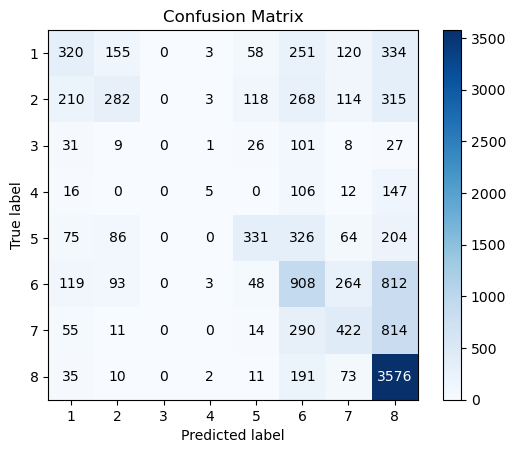

In [36]:
plot_confusion_matrix(y_test, Test_Preds)

### ROC Curve
The plot below displays the ROC curves for our model. This curve is a graph of the true positive rate versus the false positive rate for each class.


<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

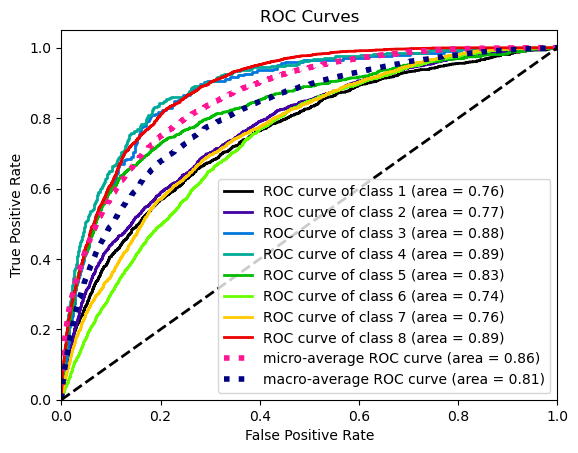

In [37]:
# Display ROC Curves
plot_roc(y_test, Test_PredProbs)

We can observe that the model has a wide range of AUC values against each class, indicating varying degrees of sensitivity/specificity across the dataset. This variability makes sense considering the data imbalance present. The data imbalance, as evidenced by the histogram of labels displayed earlier, also explains the differences in accuracy for each class displayed by the confusion matrix.

You might initially perceive the model performance as low. However, it's important to consider that the baseline for this project is the performance of the best machine learning and statistical learning models submitted as solutions to the Kaggle Competition for which this dataset was originally released. You can explore these results here [[1]](#R-1)[[10]](#R-10). Within this context, our model's performance was quite good.

Now, there are many more Keras Tuner features available for exploration, which you can incorporate into your future deep learning projects. However, by now, you've established a solid foundation, including the structure, methods, and implementations for your risk rating-related actuarial or financial classification tasks!

<a name='6'></a>  
## 6 - Bibliography

<a name='R-1'></a>  
1. Kaggle. (n.d.). Prudential Life Insurance Assessment: Evaluation. Retrieved from https://www.kaggle.com/competitions/prudential-life-insurance-assessment/overview/evaluation.
<a name='R-2'></a>  
2. Keras Tuner documentation for tuners. (n.d.). Retrieved from https://keras.io/api/keras_tuner/tuners/.
<a name='R-3'></a>  
3. Keras API documentation for metrics. (n.d.). Retrieved from https://keras.io/api/metrics/.
<a name='R-4'></a>  
4. Keras API documentation for losses. (n.d.). Retrieved from https://keras.io/api/losses/.
<a name='R-5'></a>  
5. Keras Tuner documentation for objective. (n.d.). Retrieved from https://keras.io/api/keras_tuner/tuners/objective/.
<a name='R-6'></a>  
6. Keras: Creating custom metrics. (n.d.). Retrieved from https://keras.io/api/metrics/#creating-custom-metrics.
<a name='R-7'></a>  
7. Keras. (2021, October 27). Tailoring the search space. Retrieved from https://keras.io/guides/keras_tuner/tailor_the_search_space/.
<a name='R-8'></a>  
8. Keras API documentation for Activations. Retrieved from https://keras.io/api/layers/activations/.
<a name='R-9'></a>  
9. Keras API documentation for Hyperparameters. Retrieved from https://keras.io/api/keras_tuner/hyperparameters/.
<a name='R-10'></a>  
10. Kaggle. (n.d.). Machine Learning for Risk Classification. Retrieved from https://www.kaggle.com/code/karansarpal/machine-learning-for-risk-classification-ks.
